# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:10<00:00, 5.88kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

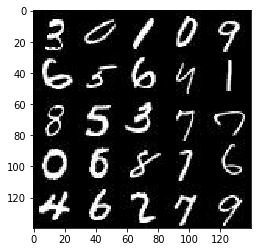

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

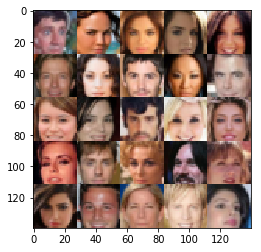

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="inputs_z")
    lr = tf.placeholder(tf.float32, name="lr")
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Slope for leaky ReLU
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 128, 4, strides=2, padding='SAME')
        x_out = tf.maximum(alpha*x, x)
        #14*14*64
        
        x1 = tf.layers.conv2d(x_out, 256, 4, strides=2, padding='SAME')
        x1_norm = tf.layers.batch_normalization(x1, training=True)
        x1_out = tf.maximum(alpha*x1_norm, x1_norm)
        x1_drop = tf.layers.dropout(x1_out, rate=0.25)
        #7*7*128
        
        x2 = tf.layers.conv2d(x1_drop, 512, 4, strides=2, padding='VALID')
        x2_norm = tf.layers.batch_normalization(x2, training=True)
        x2_out = tf.maximum(alpha*x2_norm, x2_norm)
        x2_drop = tf.layers.dropout(x2_out, rate=0.25)
        #2*2*256
        
        flatten = tf.reshape(x2_drop, (-1, 2*2*512))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: Slope for leaky ReLU
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        x_norm = tf.layers.batch_normalization(x, training=is_train)
        x_out = tf.nn.relu(x_norm)
        #2*2*512
        
        x1 = tf.layers.conv2d_transpose(x_out, 256, 5, strides=2, padding='VALID')
        x1_norm = tf.layers.batch_normalization(x1, training=is_train)
        x1_out = tf.nn.relu(x1_norm)
        x1_drop = tf.layers.dropout(x1_out, rate=0.2)
        #7*7*256
        
        x2 = tf.layers.conv2d_transpose(x1_drop, 128, 5, strides=2, padding='SAME')
        x2_norm = tf.layers.batch_normalization(x2, training=is_train)
        x2_out = tf.nn.relu(x2_norm)
        x2_drop = tf.layers.dropout(x2_out, rate=0.2)
        #14*14*128
        
        x3 = tf.layers.conv2d_transpose(x2_drop, 64, 5, strides=2, padding='SAME')
        x3_norm = tf.layers.batch_normalization(x3, training=is_train)
        x3_out = tf.nn.relu(x3_norm)
        x3_drop = tf.layers.dropout(x3_out, rate=0.2)
        #28*28*64
        
        logits = tf.layers.conv2d_transpose(x3_drop, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
        #28*28*out_channel_dim
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    alpha=0.12
    out_channel_dim = 1 if data_image_mode == "L" else 3
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z:batch_z, lr:learning_rate})
                
                if steps % 100 == 0:
                    d_train_loss = d_loss.eval({input_real:batch_images, input_z:batch_z})
                    g_train_loss = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i+1, epoch_count), 
                          "Discriminator loss: {:.4f}".format(d_train_loss), 
                          "Generator loss: {:.4f}".format(g_train_loss))
                    
                    _ = show_generator_output(sess, 4, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator loss: 0.3523 Generator loss: 4.9094


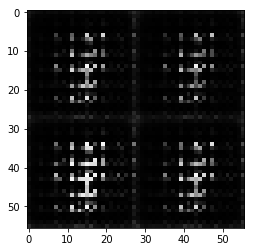

Epoch 1/2 Discriminator loss: 0.3816 Generator loss: 5.0776


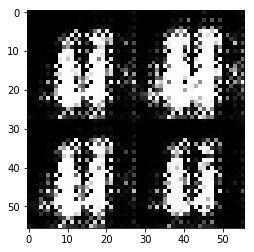

Epoch 1/2 Discriminator loss: 0.3607 Generator loss: 4.0280


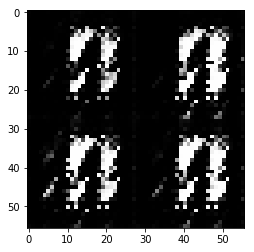

Epoch 1/2 Discriminator loss: 0.4354 Generator loss: 2.7731


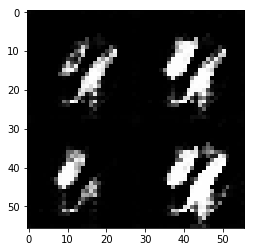

Epoch 1/2 Discriminator loss: 0.4597 Generator loss: 2.8610


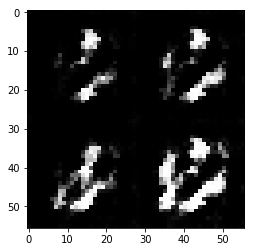

Epoch 1/2 Discriminator loss: 0.4259 Generator loss: 3.1233


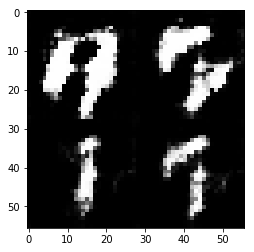

Epoch 1/2 Discriminator loss: 0.8687 Generator loss: 1.5182


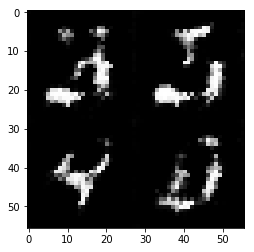

Epoch 1/2 Discriminator loss: 0.9021 Generator loss: 1.2389


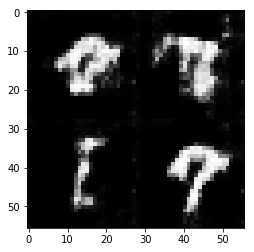

Epoch 1/2 Discriminator loss: 0.8511 Generator loss: 1.3487


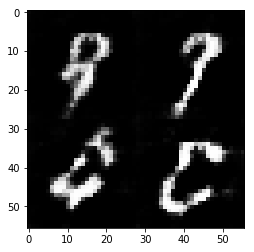

Epoch 1/2 Discriminator loss: 0.9266 Generator loss: 1.1410


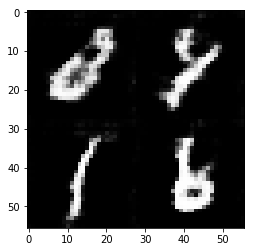

Epoch 1/2 Discriminator loss: 0.8881 Generator loss: 2.2677


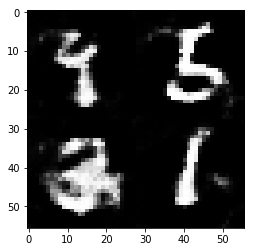

Epoch 1/2 Discriminator loss: 0.8754 Generator loss: 1.3532


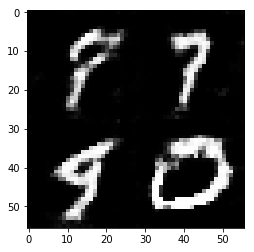

Epoch 1/2 Discriminator loss: 0.8544 Generator loss: 1.4604


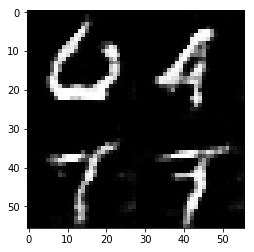

Epoch 1/2 Discriminator loss: 0.8948 Generator loss: 1.4309


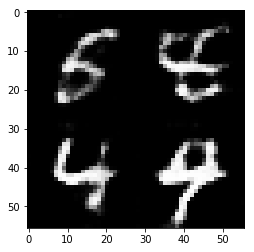

Epoch 1/2 Discriminator loss: 0.9270 Generator loss: 1.0655


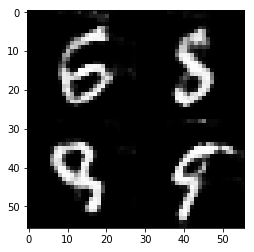

Epoch 1/2 Discriminator loss: 0.6652 Generator loss: 1.9944


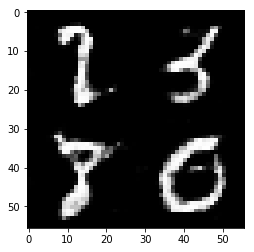

Epoch 1/2 Discriminator loss: 0.9995 Generator loss: 1.0200


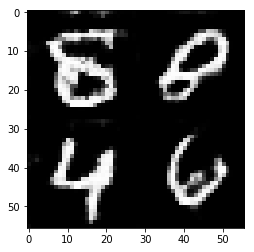

Epoch 1/2 Discriminator loss: 0.8151 Generator loss: 1.2505


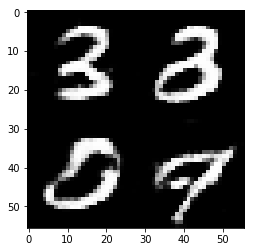

Epoch 2/2 Discriminator loss: 0.7131 Generator loss: 1.6405


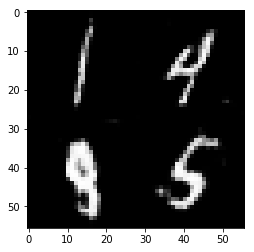

Epoch 2/2 Discriminator loss: 0.7811 Generator loss: 1.2726


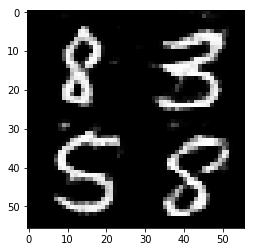

Epoch 2/2 Discriminator loss: 0.7814 Generator loss: 1.4572


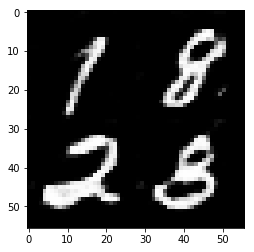

Epoch 2/2 Discriminator loss: 0.8719 Generator loss: 1.3513


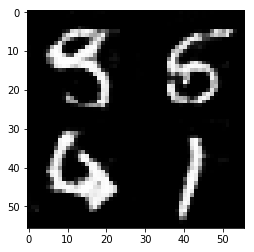

Epoch 2/2 Discriminator loss: 1.0154 Generator loss: 0.8875


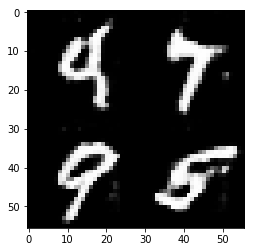

Epoch 2/2 Discriminator loss: 1.0484 Generator loss: 0.7926


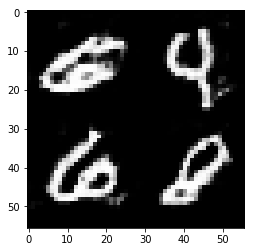

Epoch 2/2 Discriminator loss: 0.8465 Generator loss: 1.3972


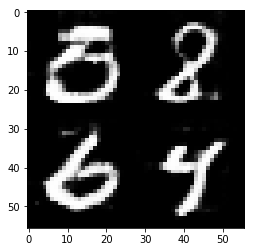

Epoch 2/2 Discriminator loss: 1.0476 Generator loss: 0.8931


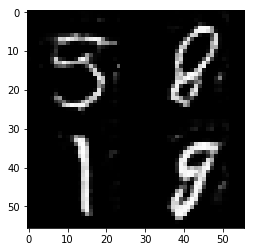

Epoch 2/2 Discriminator loss: 0.9379 Generator loss: 1.0577


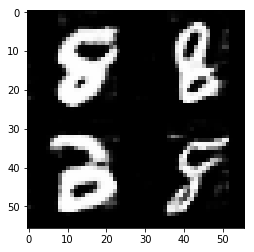

Epoch 2/2 Discriminator loss: 0.8643 Generator loss: 1.1443


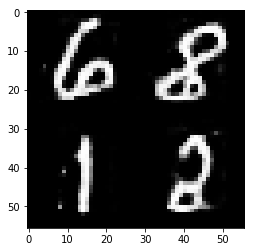

Epoch 2/2 Discriminator loss: 1.0325 Generator loss: 0.9087


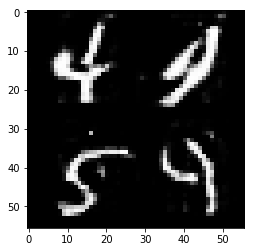

Epoch 2/2 Discriminator loss: 0.8288 Generator loss: 1.3039


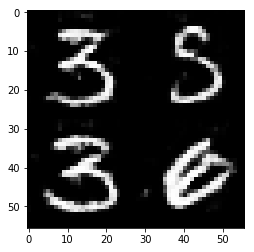

Epoch 2/2 Discriminator loss: 0.7240 Generator loss: 1.6100


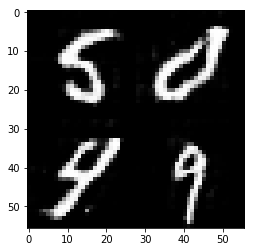

Epoch 2/2 Discriminator loss: 0.9454 Generator loss: 1.5181


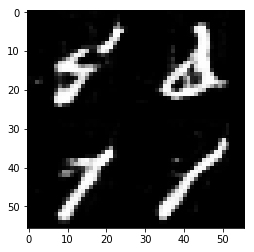

Epoch 2/2 Discriminator loss: 0.7155 Generator loss: 1.4165


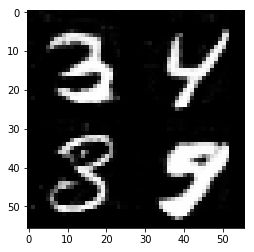

Epoch 2/2 Discriminator loss: 0.8940 Generator loss: 1.0319


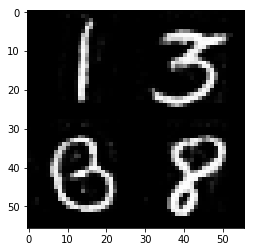

Epoch 2/2 Discriminator loss: 0.8590 Generator loss: 1.1853


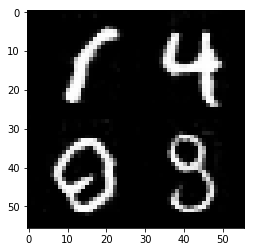

Epoch 2/2 Discriminator loss: 1.0212 Generator loss: 0.8288


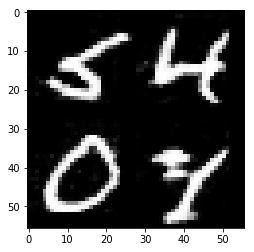

Epoch 2/2 Discriminator loss: 1.2202 Generator loss: 0.6561


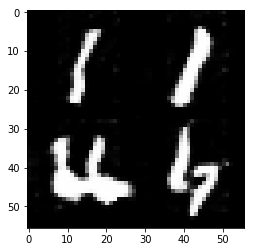

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator loss: 0.4753 Generator loss: 2.4874


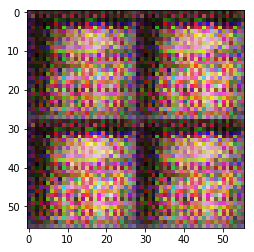

Epoch 1/1 Discriminator loss: 0.7631 Generator loss: 1.6334


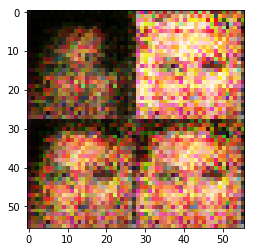

Epoch 1/1 Discriminator loss: 0.7566 Generator loss: 1.3931


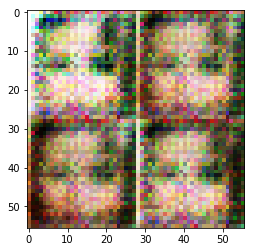

Epoch 1/1 Discriminator loss: 0.7841 Generator loss: 1.4248


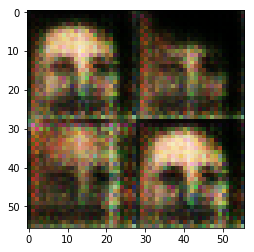

Epoch 1/1 Discriminator loss: 0.6477 Generator loss: 1.8989


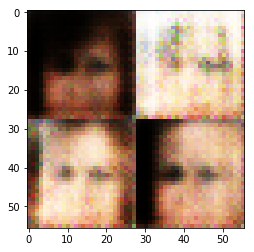

Epoch 1/1 Discriminator loss: 0.5537 Generator loss: 2.0874


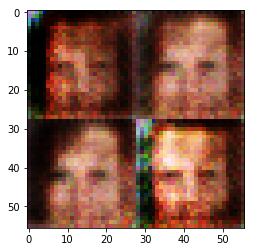

Epoch 1/1 Discriminator loss: 0.9201 Generator loss: 1.1584


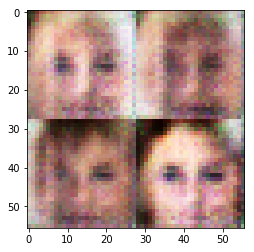

Epoch 1/1 Discriminator loss: 0.4931 Generator loss: 2.5248


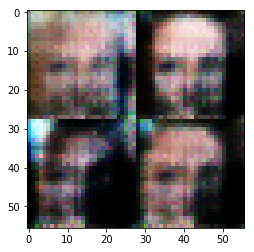

Epoch 1/1 Discriminator loss: 0.7728 Generator loss: 1.2211


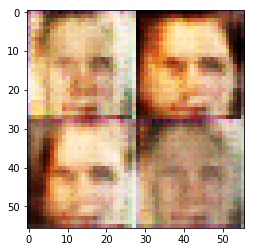

Epoch 1/1 Discriminator loss: 0.6755 Generator loss: 1.7135


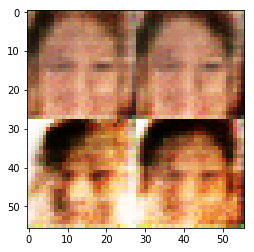

Epoch 1/1 Discriminator loss: 0.9732 Generator loss: 0.9657


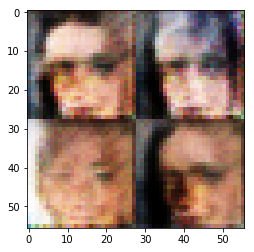

Epoch 1/1 Discriminator loss: 0.5646 Generator loss: 2.9794


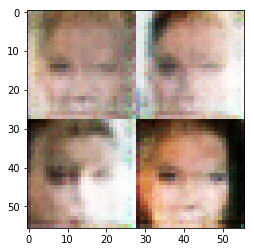

Epoch 1/1 Discriminator loss: 0.7709 Generator loss: 1.4486


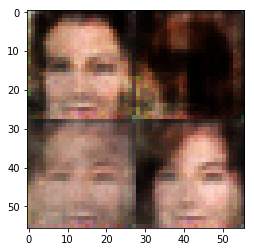

Epoch 1/1 Discriminator loss: 0.6186 Generator loss: 1.9342


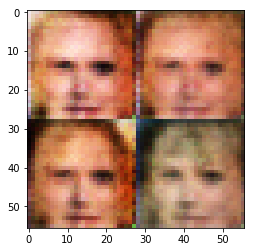

Epoch 1/1 Discriminator loss: 0.7306 Generator loss: 1.6869


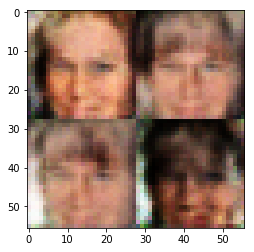

Epoch 1/1 Discriminator loss: 0.6094 Generator loss: 1.7832


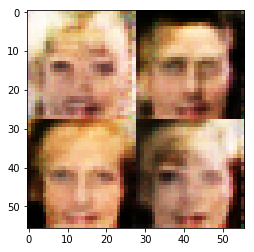

Epoch 1/1 Discriminator loss: 0.7450 Generator loss: 1.3729


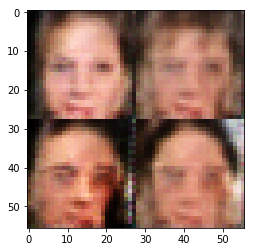

Epoch 1/1 Discriminator loss: 0.6975 Generator loss: 3.1225


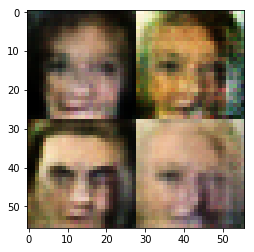

Epoch 1/1 Discriminator loss: 0.7822 Generator loss: 1.2032


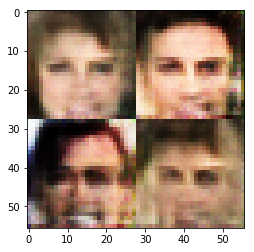

Epoch 1/1 Discriminator loss: 0.9513 Generator loss: 1.0485


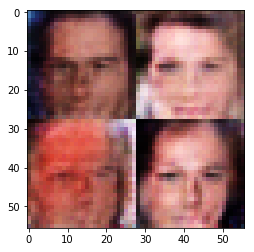

Epoch 1/1 Discriminator loss: 0.6808 Generator loss: 1.5902


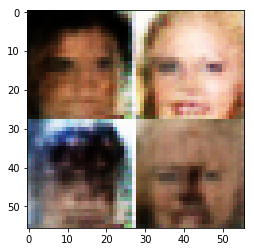

Epoch 1/1 Discriminator loss: 0.9704 Generator loss: 0.9580


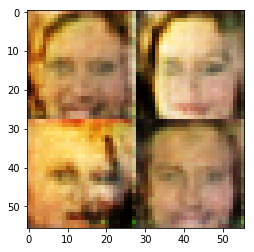

Epoch 1/1 Discriminator loss: 0.5415 Generator loss: 2.0126


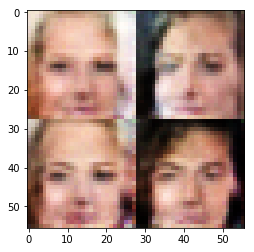

Epoch 1/1 Discriminator loss: 0.8502 Generator loss: 1.1266


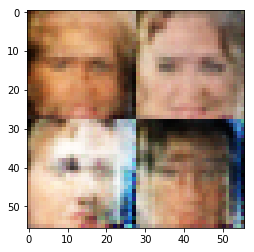

Epoch 1/1 Discriminator loss: 0.7862 Generator loss: 1.3113


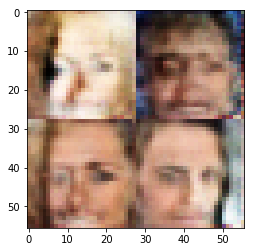

Epoch 1/1 Discriminator loss: 0.6669 Generator loss: 2.6902


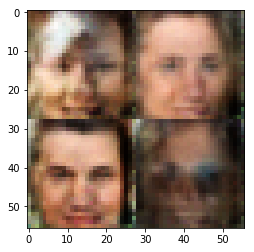

Epoch 1/1 Discriminator loss: 0.8764 Generator loss: 1.1332


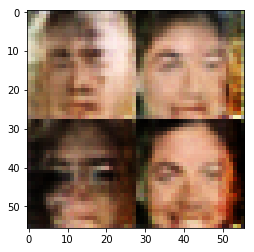

Epoch 1/1 Discriminator loss: 0.7711 Generator loss: 1.4329


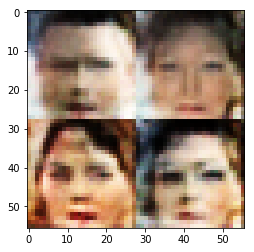

Epoch 1/1 Discriminator loss: 0.6996 Generator loss: 1.5460


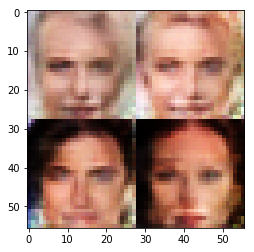

Epoch 1/1 Discriminator loss: 0.8615 Generator loss: 1.0924


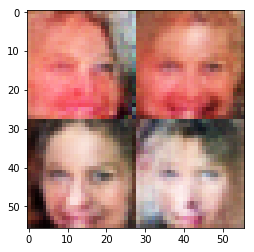

Epoch 1/1 Discriminator loss: 0.7839 Generator loss: 2.0537


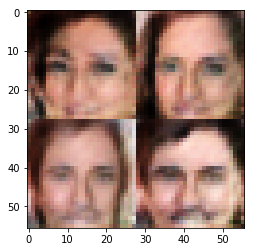

Epoch 1/1 Discriminator loss: 0.9609 Generator loss: 1.0080


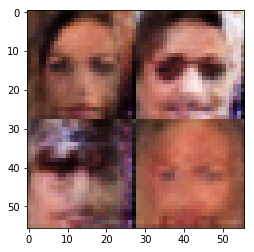

Epoch 1/1 Discriminator loss: 0.7356 Generator loss: 1.7950


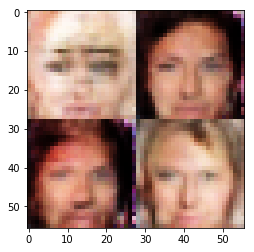

Epoch 1/1 Discriminator loss: 1.1360 Generator loss: 0.7222


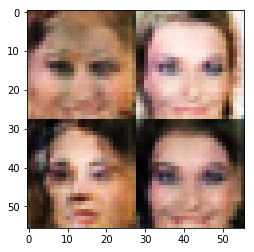

Epoch 1/1 Discriminator loss: 0.6505 Generator loss: 1.5811


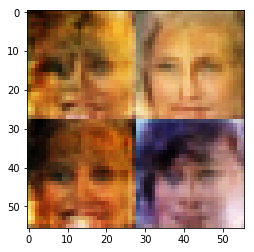

Epoch 1/1 Discriminator loss: 0.6945 Generator loss: 2.4872


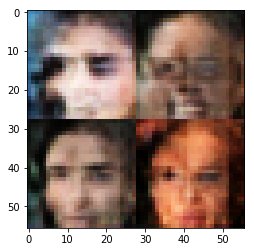

Epoch 1/1 Discriminator loss: 0.7677 Generator loss: 1.6063


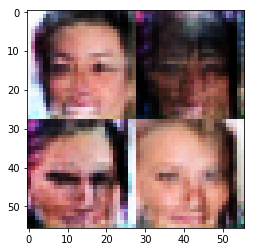

Epoch 1/1 Discriminator loss: 0.6708 Generator loss: 1.8423


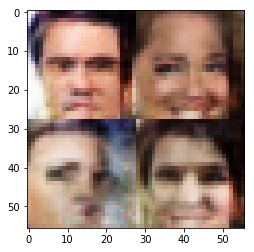

Epoch 1/1 Discriminator loss: 0.6023 Generator loss: 2.2937


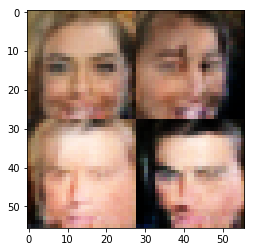

Epoch 1/1 Discriminator loss: 0.7706 Generator loss: 1.3077


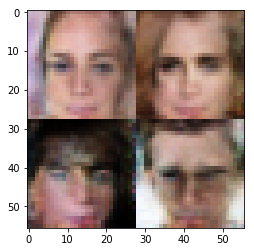

Epoch 1/1 Discriminator loss: 0.9064 Generator loss: 1.0203


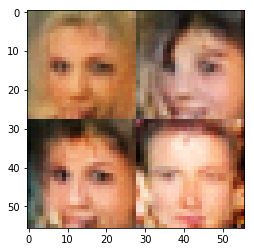

Epoch 1/1 Discriminator loss: 0.6767 Generator loss: 2.8093


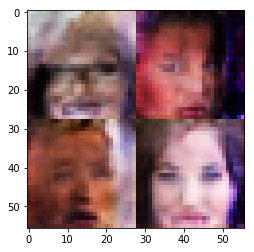

Epoch 1/1 Discriminator loss: 1.2435 Generator loss: 0.6020


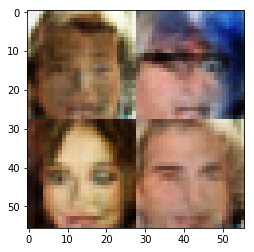

Epoch 1/1 Discriminator loss: 0.7630 Generator loss: 1.4536


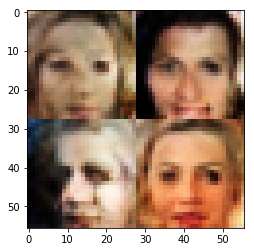

Epoch 1/1 Discriminator loss: 0.8932 Generator loss: 1.2909


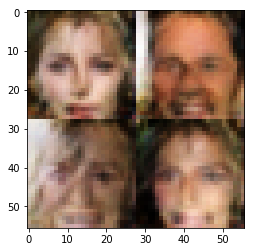

Epoch 1/1 Discriminator loss: 0.9285 Generator loss: 0.9208


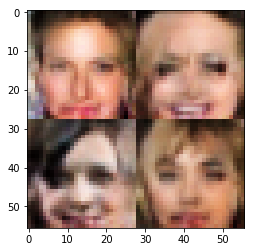

Epoch 1/1 Discriminator loss: 0.7143 Generator loss: 1.5819


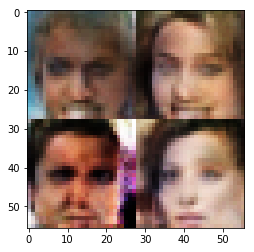

Epoch 1/1 Discriminator loss: 1.1623 Generator loss: 0.7271


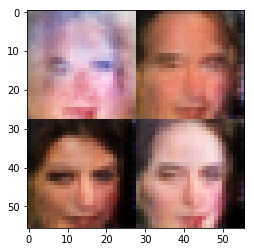

Epoch 1/1 Discriminator loss: 1.0896 Generator loss: 0.7353


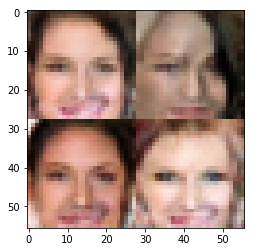

Epoch 1/1 Discriminator loss: 1.0781 Generator loss: 0.9872


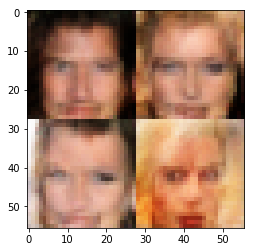

Epoch 1/1 Discriminator loss: 0.8082 Generator loss: 1.1625


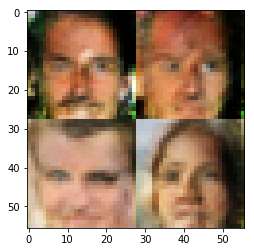

Epoch 1/1 Discriminator loss: 1.0740 Generator loss: 0.7578


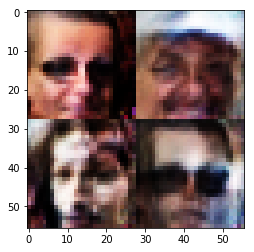

Epoch 1/1 Discriminator loss: 0.7898 Generator loss: 1.3409


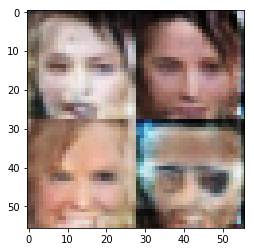

Epoch 1/1 Discriminator loss: 0.9969 Generator loss: 0.9147


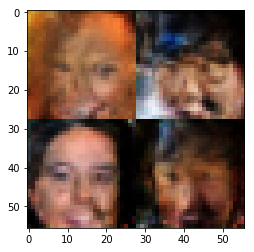

Epoch 1/1 Discriminator loss: 0.8051 Generator loss: 1.4199


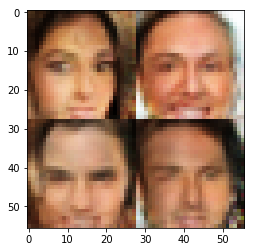

Epoch 1/1 Discriminator loss: 0.9505 Generator loss: 1.1454


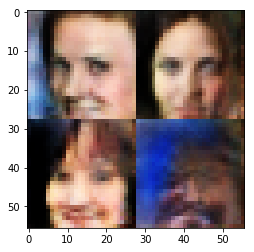

Epoch 1/1 Discriminator loss: 1.0046 Generator loss: 0.8752


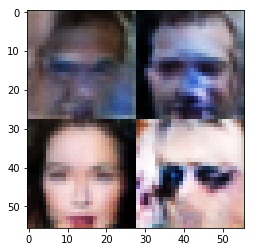

Epoch 1/1 Discriminator loss: 0.8642 Generator loss: 1.0756


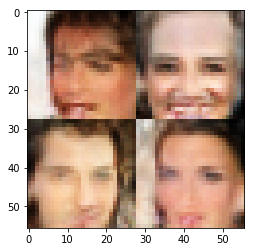

Epoch 1/1 Discriminator loss: 0.9344 Generator loss: 1.0777


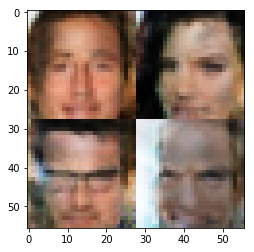

Epoch 1/1 Discriminator loss: 0.7770 Generator loss: 1.4958


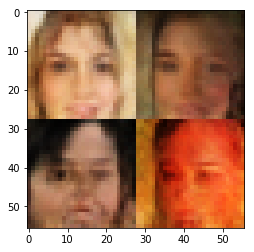

Epoch 1/1 Discriminator loss: 0.9062 Generator loss: 1.0899


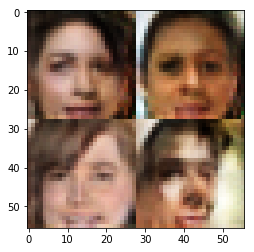

Epoch 1/1 Discriminator loss: 1.3265 Generator loss: 0.6079


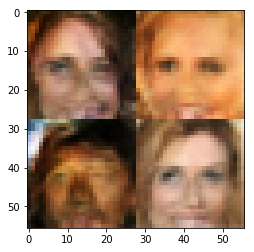

Epoch 1/1 Discriminator loss: 0.7887 Generator loss: 1.4683


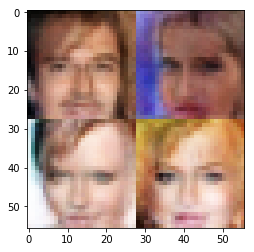

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.